In [1]:
import pandas as pd 
import numpy as np 
import datetime
import matplotlib.pyplot as plt 
from matplotlib import lines, patches
from matplotlib.patches import Patch
from matplotlib.patheffects import withStroke
import copy
from flexitext import flexitext
import seaborn as sns 
import statsmodels.api as sm
from stargazer.stargazer import Stargazer, LineLocation

# My code is here (:
from Graphs import ColorConstants as cc
from Graphs.MyRcParams import mympl 
from data_helpers import remove_string, filter_extremes_values, summary_stats, correlation_matrix

In [2]:
# Runs the script that filters the raw HMDA data - takes a while to run
#%timeit
#%run clean_data.py

In [3]:
in_df = pd.read_csv('Cleaned Data.csv')

C:\Users\peter\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3418: DtypeWarning: Columns (20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
in_df.shape

(3660509, 80)

In [5]:
non_white = in_df[in_df['White'] == 0]
white = in_df[in_df['White'] == 1].sample(n=in_df[in_df['White'] == 0].shape[0])
df = pd.concat([non_white, white])
print(df.shape, df.shape[0] / 2)

(670418, 80) 335209.0


## Interest Rate 

In [6]:
df = df.drop(columns=['Unnamed: 0',
'state_code_nan',
'state_code_PR',
'state_code_GU',
'state_code_VI',
'Minority'])
df = df.drop(columns=['Tract to MSA Income Ratio.1','Tract to MSA Income Ratio.2', 'Tract to MSA Income Ratio.3'])
df = df[df['Owner Occupied Per Capita'] != 0]
df['Loan-Income Ratio'] = df['Loan-Income Ratio'] * 100 # Want this to be in percentage points

approval_df = df.drop(columns=['Loan-Value Ratio', # Only for approved loans (:
                               'Interest Rate'])

#print(approval_df.shape)
approval_df = remove_string(approval_df, columns=approval_df.columns)
approval_df = filter_extremes_values(approval_df)
approval_stats = summary_stats(approval_df)
# Show most skewed and least skewed values
display(approval_stats.sort_values('Skew').head(5))
display(approval_stats.sort_values('Skew').tail(5))
approval_stats.to_excel('approval_stats.xlsx')
print(approval_df.shape)
approval_df.to_csv('Final Data.csv')

,Count,Minimum,25th,50th,75th,Maximum,Mean,SDV,Kurtosis,Skew
Not Hispanic,625347.0,0.000000,1.000000,1.000000,1.00000,1.000000,0.909722,0.286580,6.176207,-2.859403
Home Purchase,625347.0,0.000000,1.000000,1.000000,1.00000,1.000000,0.828868,0.376625,1.049919,-1.746401
Loan Approved,625347.0,0.000000,1.000000,1.000000,1.00000,1.000000,0.785628,0.410386,-0.062339,-1.391999
Male,625347.0,0.000000,0.000000,1.000000,1.00000,1.000000,0.586844,0.492401,-1.875582,-0.352737
Owner Occupied Per Capita,625347.0,0.055325,21.496905,26.783479,30.83871,71.802773,25.863801,7.325363,0.667050,-0.339418


,Count,Minimum,25th,50th,75th,Maximum,Mean,SDV,Kurtosis,Skew
state_code_AK,625347.0,0.0,0.0,0.0,0.0,1.0,0.001516,0.038906,654.655496,25.625249
state_code_ND,625347.0,0.0,0.0,0.0,0.0,1.0,0.001418,0.037635,700.020556,26.495628
state_code_HI,625347.0,0.0,0.0,0.0,0.0,1.0,0.001370,0.036994,724.700292,26.957336
state_code_VT,625347.0,0.0,0.0,0.0,0.0,1.0,0.001252,0.035363,793.662781,28.207450
state_code_WY,625347.0,0.0,0.0,0.0,0.0,1.0,0.001151,0.033912,863.545567,29.420109


(625347, 69)


##  Graph Constants

In [7]:
SOURCE_TEXT = 'Source: 2020 HMDA Data Release'
DPI = 100
PAD_CONSTANT = 0.02
FIG_SIZE = (12, 7)
PATH_EFFECTS = [withStroke(linewidth=10, foreground='white')]

source_text_color = "#a2a2a2"
source_font_size = 14
# Set broad params 
mympl() # Runs my basic RCParam function - note there is a glitch rn with this version of matplot, bottom bar

## Correlation Matrix

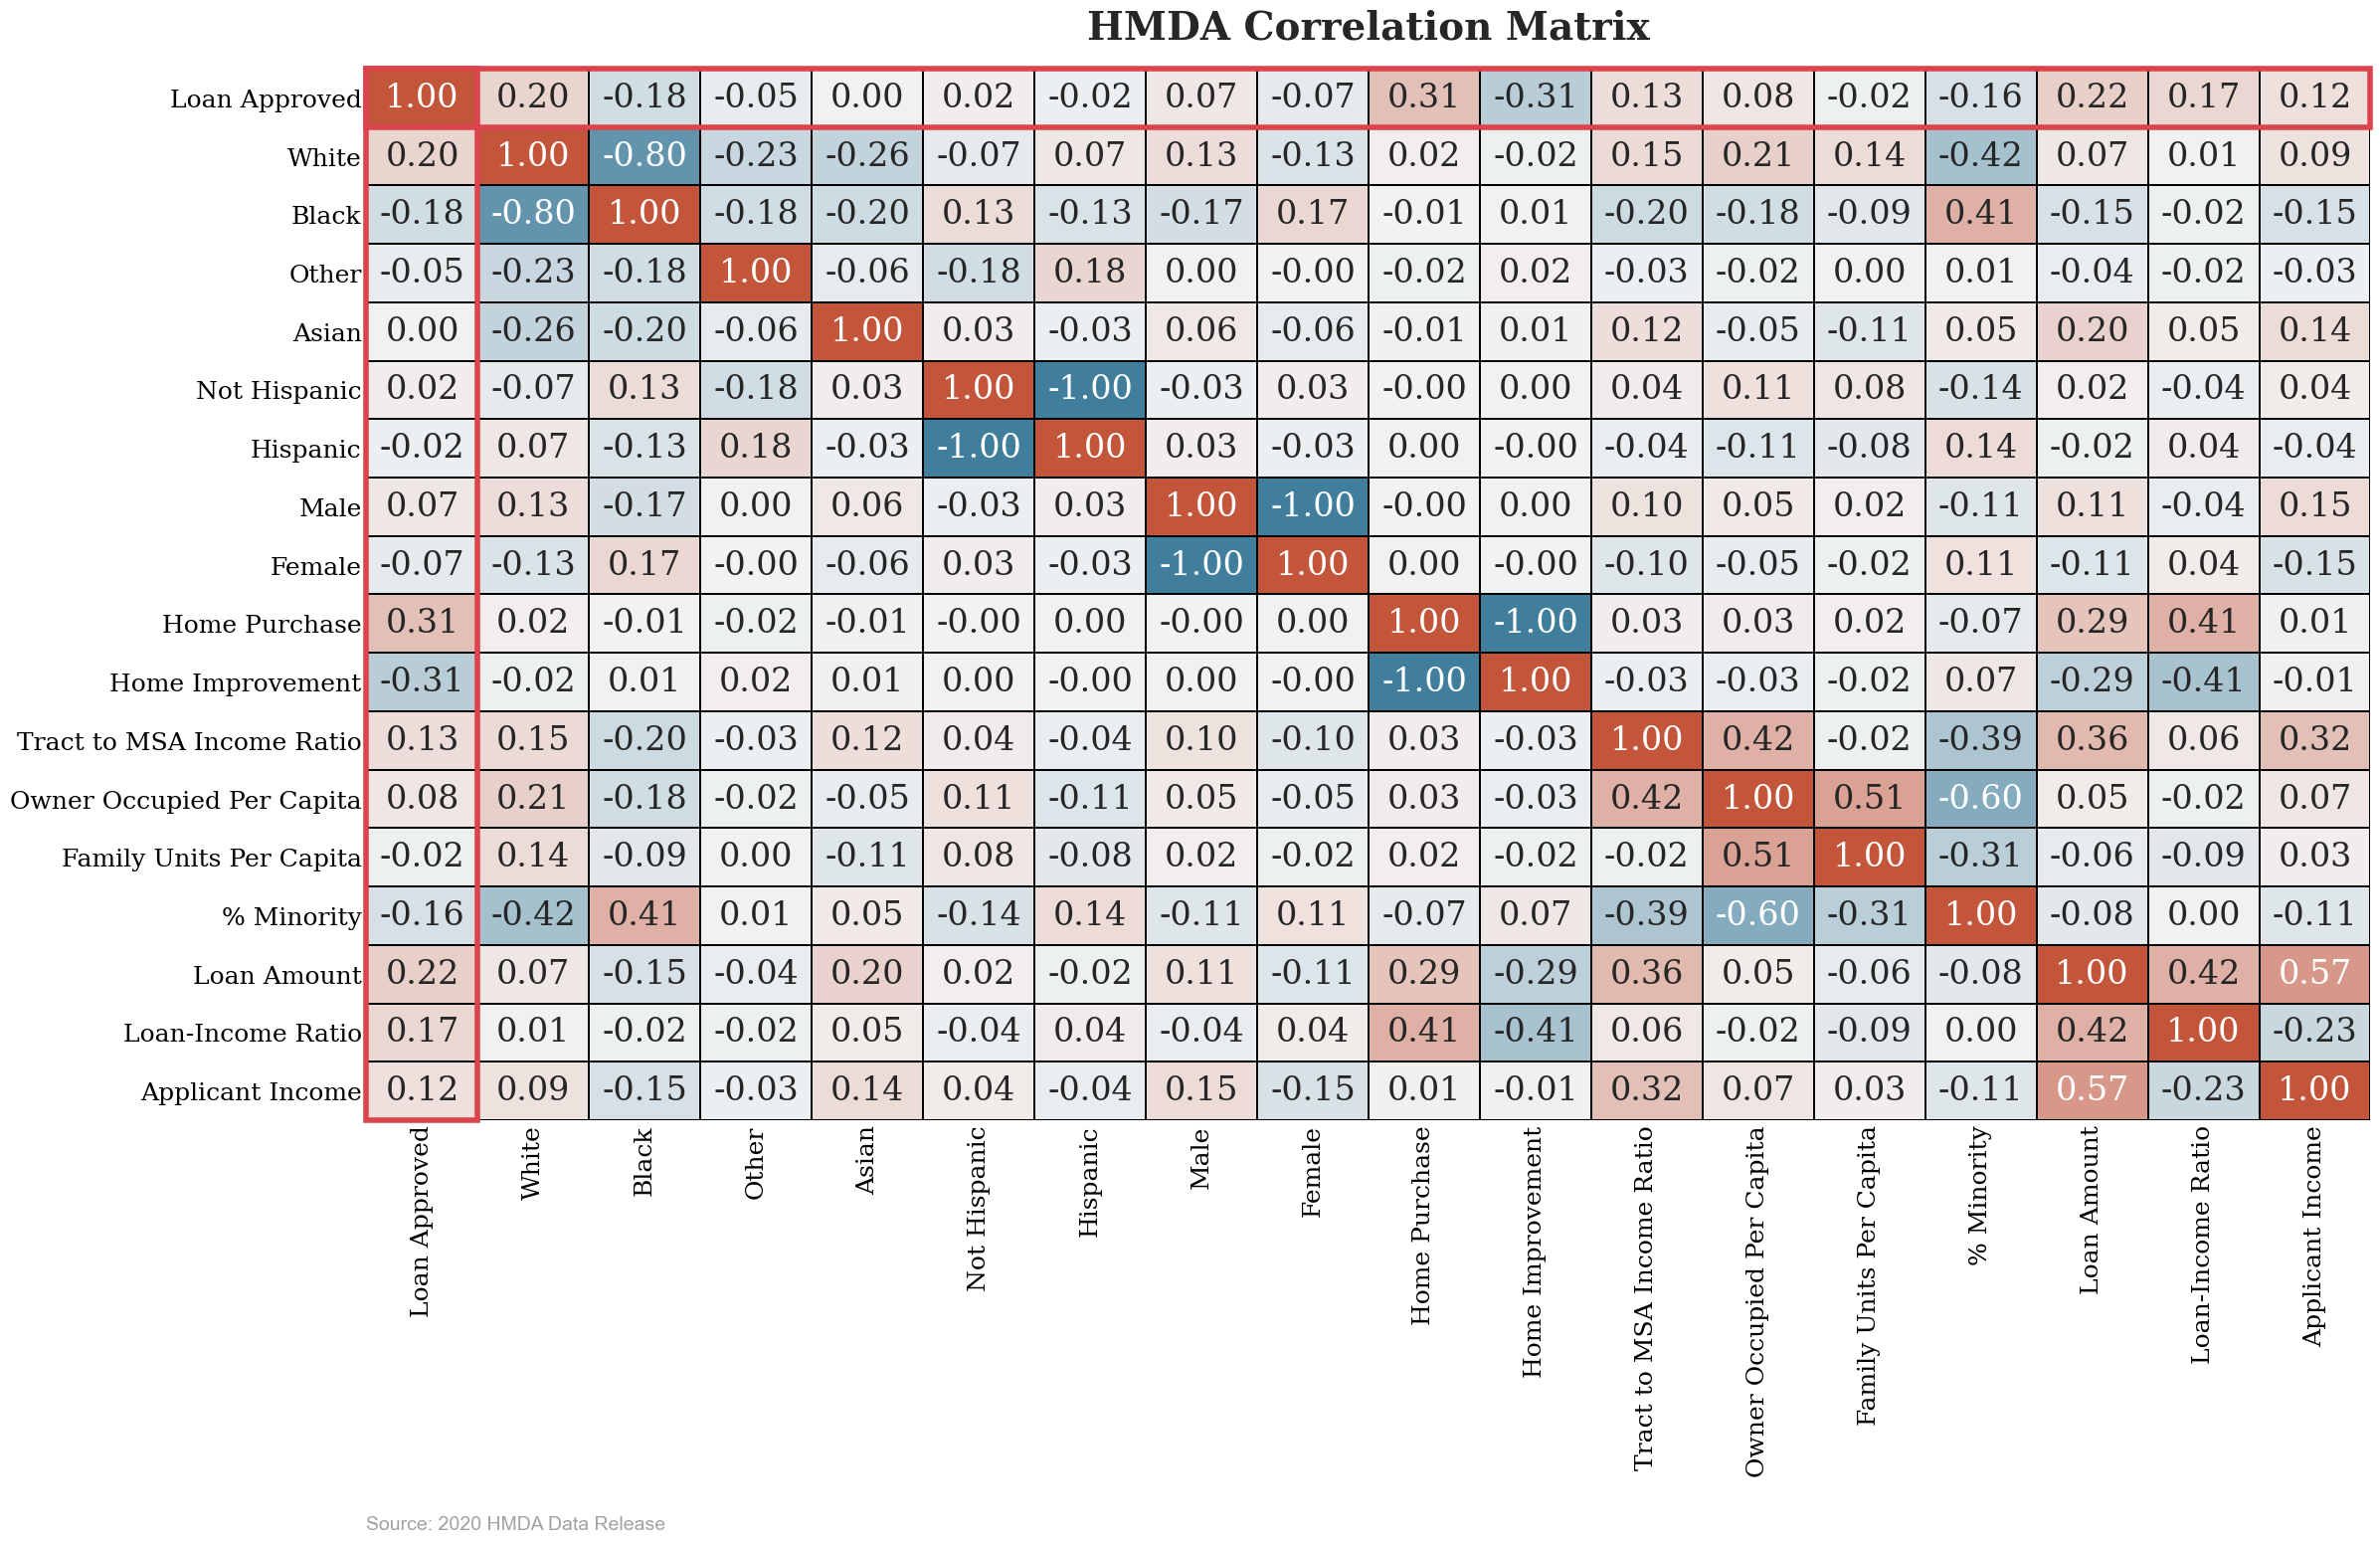

In [33]:
correlation_matrix(approval_df, title='HMDA Correlation Matrix', wanted_label='Loan Approved')

## Part 2. How does race affect mortgage loan approval ?

In [9]:
exclude_dummies = ['White', 'Not Hispanic', 'Male', 'Home Purchase']

race_x = ['Black', 'Other', 'Asian']
purpose_x = ['Male']
hispanic_x = ['Not Hispanic']
sex_x = ['Home Purchase']
dummy_xs = race_x + purpose_x + hispanic_x + sex_x
dep_var = ['Loan Approved']
other_x = [col for col in approval_df.columns\
           if (col not in race_x)\
           and (col not in exclude_dummies)\
           and (col not in dep_var)\
           and ('state_code' not in col)\
           and ('Not Hispanic' not in col)\
           and ('Male' not in col)\
           and ('Home Purchase' not in col)\
           #and ('Minority' not in col)
          ]
state_cols = [col for col in approval_df.columns if 'state_code' in col and col != 'state_code_MA']

In [10]:
approval_variables = race_x + other_x
approval_regressions = []
reg_vars = []
for var in approval_variables:
    reg_vars.append(var) 
    X = approval_df[reg_vars]
    y = approval_df[dep_var]
    X = sm.add_constant(X)
    model = sm.Logit(y, X).fit()
    approval_regressions.append(model)
    
reg_vars += state_cols 
X = approval_df[reg_vars]
y = approval_df[dep_var]
X = sm.add_constant(X)
approval_df_state_model = sm.Logit(y, X).fit()

C:\Users\peter\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 0.503883
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.500127
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.499041
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.498307
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.497643
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.454144
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.450054
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.449824
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.448485
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.448224
  

In [11]:
# Creates a basic regression table in Excel. I need this because I have too many regressors 

with_stars = []
for regression in approval_regressions + [approval_df_state_model]:
    reg_html = regression.summary().tables[1].as_html()
    dataframe = pd.read_html(reg_html, header=0, index_col=0)[0]
    dataframe['Stars'] = dataframe['P>|z|'].apply(lambda x: '***' if x < 0.01\
                                                  else('**' if x < 0.05 else( '*' if x < 0.1 else None))) 
    dataframe['std err'] = dataframe['std err'].round(3)
    dataframe['std err'] = dataframe['std err'].astype(str)
    dataframe['std err'] = dataframe['std err'].apply(lambda x: '(' + str(x) + ')')
    dataframe['coef'] = dataframe['coef'].round(3)
    dataframe['coef'] = dataframe['coef'].astype(str)
    dataframe['coef'] = dataframe['coef'] + dataframe['Stars']
    dataframe = dataframe.drop(columns=['P>|z|', '[0.025', '0.975]', 'z', 'Stars'])
    with_stars.append(dataframe.T)
regression_table = pd.concat(with_stars)
regression_table.to_excel('My Regression Table.xlsx')
regression_table

,const,Black,Other,Asian,Hispanic,Female,Home Improvement,Tract to MSA Income Ratio,Owner Occupied Per Capita,Family Units Per Capita,...,state_code_WV,state_code_VA,state_code_RI,state_code_IA,state_code_MD,state_code_AK,state_code_SD,state_code_HI,state_code_ME,state_code_VT
coef,1.683***,-0.878***,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std err,(0.004),(0.006),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
coef,1.784***,-0.978***,-0.962***,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std err,(0.005),(0.007),(0.013),NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
coef,1.848***,-1.043***,-1.026***,-0.523***,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std err,(0.005),(0.007),(0.013),(0.014),NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
coef,1.889***,-1.069***,-0.958***,-0.542***,-0.337***,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std err,(0.005),(0.007),(0.014),(0.014),(0.011),NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
coef,1.957***,-1.04***,-0.948***,-0.552***,-0.341***,-0.185***,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std err,(0.006),(0.007),(0.014),(0.014),(0.011),(0.006),NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
results_summary = approval_df_state_model.summary()
results_as_html = results_summary.tables[1].as_html()
approval_results = pd.read_html(results_as_html, header=0, index_col=0)[0]
approval_results['Odds Ratio'] = np.exp(approval_results['coef'])
#Get the average marginal probabilities
marginal_model = approval_df_state_model.get_margeff(at='mean')
marginal_summary = marginal_model.summary()
marginal_results_as_html = marginal_summary.tables[1].as_html()
marginal_results_table = pd.read_html(marginal_results_as_html, header=0, index_col=0)[0]
marginal_results_table = marginal_results_table.rename(columns={'dy/dx': 'AVG Marginal Probability'})
final_results = pd.merge(how='left', left=approval_results, 
                         right=marginal_results_table['AVG Marginal Probability'], 
                         left_index=True,
                         right_index=True)
final_results.to_excel('Final Results.xlsx')

In [13]:
pd.set_option('display.max_rows', None)
display(final_results)

,coef,std err,z,P>|z|,[0.025,0.975],Odds Ratio,AVG Marginal Probability
const,1.9099,0.036000,53.732,0.000,1.840,1.980,6.752414,NaN
Black,-0.8414,0.009000,-96.402,0.000,-0.858,-0.824,0.431107,-0.115000
Other,-0.8421,0.015000,-55.034,0.000,-0.872,-0.812,0.430805,-0.115100
Asian,-0.8705,0.016000,-54.748,0.000,-0.902,-0.839,0.418742,-0.119000
Hispanic,-0.3069,0.012000,-25.018,0.000,-0.331,-0.283,0.735724,-0.042000
Female,-0.1074,0.007000,-15.262,0.000,-0.121,-0.094,0.898166,-0.014700
Home Improvement,-1.5493,0.009000,-167.058,0.000,-1.567,-1.531,0.212397,-0.211800
Tract to MSA Income Ratio,0.0026,0.000000,22.414,0.000,0.002,0.003,1.002603,0.000400
Owner Occupied Per Capita,0.0075,0.001000,10.449,0.000,0.006,0.009,1.007528,0.001000
Family Units Per Capita,-0.0107,0.000000,-33.707,0.000,-0.011,-0.010,0.989357,-0.001500


approval_df_state_model

In [14]:
# sg_approval = Stargazer(approval_regressions)
# sg_approval.covariate_order(approval_variables)

# sg_approval_state = Stargazer(approval_regressions + [approval_df_state_model])
# sg_approval_state.covariate_order(reg_vars)
# #print(sg_approval.render_latex())

In [15]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

In [16]:
vif_data.sort_values(['VIF'], ascending=False).to_excel('VIF Results.xlsx')
display(vif_data)

,Variable,VIF
0,const,97.621795
1,Black,1.524648
2,Other,1.121822
3,Asian,1.152983
4,Hispanic,1.132436
5,Female,1.052446
6,Home Improvement,1.310201
7,Tract to MSA Income Ratio,1.765054
8,Owner Occupied Per Capita,2.356873
9,Family Units Per Capita,1.571964


In [17]:
def sigmoid(x): # Logistic Function
    return 1 / (1 + np.exp(-x))

non_dummies = [col for col in approval_df.columns if max(approval_df[col]) > 1]
state_cols = [col for col in approval_df.columns if 'state' in col]
dummies = [col for col in approval_df.columns\
           if col not in non_dummies\
           and col not in state_cols\
           and col not in exclude_dummies\
           and col != 'Loan Approved']
avg_vals = {}
for col in non_dummies:
    avg_vals[col] = approval_df[col].mean()
base_dummies = {'Home Improvement' : 0,
               'Female' : 0,
               'const': 1,
               'Hispanic': 0}
race_cols = ['White', 'Black', 'Other', 'Asian']

In [18]:
made_up_results = {}
for state_col in state_cols:
    state_preicted = [] # Put each race
    state_lookup = {state_col: 0 for state_col in state_cols}
    state_lookup[state_col] = 1
    for race_col in race_cols:
        z = 0
        race_lookup = {race_col: 0 for race_col in race_cols}
        if race_col != 'White':
            race_lookup[race_col] = 1
        for col, val in approval_df_state_model.params.items():
            if col in non_dummies:
                z += avg_vals[col] * val
            if col in base_dummies:
                z += base_dummies[col] * val
            if col in state_cols:
                z += state_lookup[col] * val
            if col in race_cols:
                z += race_lookup[col] * val
        state_preicted.append(sigmoid(z))
    made_up_results[state_col[-2:]] = state_preicted    

# Charts:

### Chart 1: Probability of each race getting a loan in Mass

### Chart 2: Minority gap for each state  


In [19]:
state_labels = [state[-2:] for state in state_cols]
white_data = []
black_data = []
other_data = []
asian_data = []
for state_data in made_up_results.values():
    white_data.append(state_data[0])
    black_data.append(state_data[1])
    other_data.append(state_data[2])
    asian_data.append(state_data[3])

In [20]:
race_df = pd.DataFrame([white_data, black_data, other_data, asian_data])
race_df.columns = state_labels
race_df = race_df.T
race_df.columns = race_cols

race_df['W_B_Gap'] = race_df['White'] - race_df['Black']
worst_5 = list(race_df.sort_values('W_B_Gap', ascending=False).iloc[0:5].index)
best_5 = list(race_df.sort_values('W_B_Gap', ascending=True).iloc[0:5].index)

Text(0, 0.92, 'Geographic Inequality in Mortgage Loan Approval')

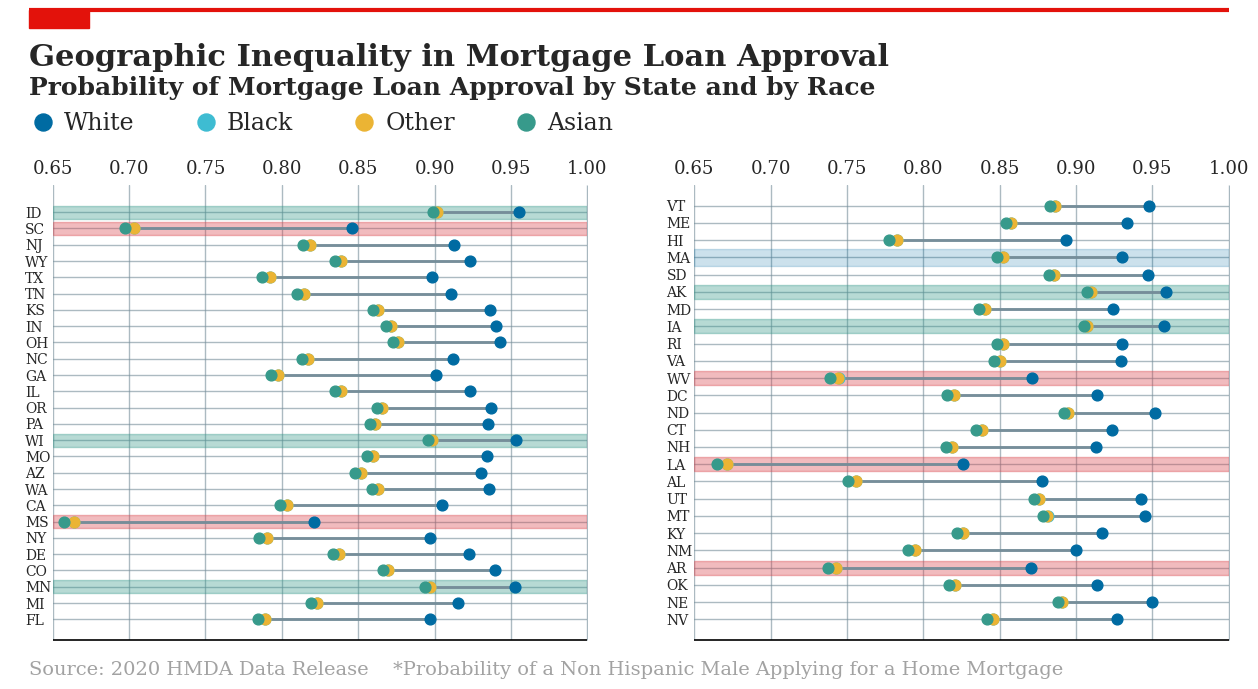

In [21]:
mympl(backround_color='white')

def get_make_color_bar(axes, label, labels, color=cc.RED):
    index = labels.index(label)
    axes.axhspan(index -.4, index +.4, alpha=0.2, color=color, label='_nolegend_')
    
fig, axes = plt.subplots(1, 2, figsize=(12, 7), dpi=DPI)
for ax in axes:
    ax.set_axisbelow(True)
    ax.spines["bottom"].set_visible(True)
    ax.spines["bottom"].set_capstyle("butt")
    ax.spines["bottom"].set_lw(1.2)
    ax.spines["bottom"].set_color('black')
    ax.spines["right"].set_visible(True)
    ax.spines["right"].set_capstyle("butt")
    ax.spines["right"].set_lw(.45)
    ax.spines["right"].set_color(cc.GRID_COLOR)
    
    
    ax.xaxis.set_tick_params(labelbottom=False, length=0)
    ax.yaxis.set_tick_params(length=3, width=1.2)
    ax.tick_params(left=False)
    ax.grid(which="major", axis='both', color=cc.GRID_COLOR, alpha=0.6, zorder=1)
    
d1_labels = state_labels[0:26] 
    
r = np.arange(len(d1_labels))
axes[0].yaxis.set_ticks(r)
axes[0].yaxis.set_ticklabels(d1_labels, fontsize=10, fontweight=100,  ha='left')
axes[0].yaxis.set_tick_params(length=6, width=1.2, pad=14)
axes[1].axhspan(20.5, 21.5, alpha=0.2, color=cc.BLUE, label='_nolegend_')


i = 0
for w, b, o, a in zip(white_data[0:26], black_data[0:26], other_data[0:26], asian_data[0:26]):
    axes[0].hlines(y=i, xmin=w, xmax=b, 
                   color='#758D99', zorder=2, linewidth=2, alpha=.8, label='_nolegend_' )
    axes[0].hlines(y=i, xmin=o, xmax=a, 
                   color='#758D99', zorder=2, linewidth=2, alpha=.8, label='_nolegend_' )
    axes[0].hlines(y=i, xmin=w, xmax=o, 
                   color='#758D99', zorder=2, linewidth=2, alpha=.8, label='_nolegend_' )
    axes[0].hlines(y=i, xmin=b, xmax=a, 
                   color='#758D99', zorder=2, linewidth=2, alpha=.8, label='_nolegend_' )
   
    axes[0].scatter(w, i, s=60, color=cc.BAR_COLORS[0], zorder=3, label='White')
    axes[0].scatter(b, i, s=60, color=cc.BAR_COLORS[1], zorder=3, label='Black')
    axes[0].scatter(o, i, s=60, color=cc.BAR_COLORS[2], zorder=3, label='Other')
    axes[0].scatter(a, i, s=60, color=cc.BAR_COLORS[3], zorder=3, label='Asian')
    i += 1

legend = axes[0].legend(['White', 'Black', 'Other', 'Asian'], loc=(-.08, 1.09), ncol=4, 
               frameon=False, handletextpad=-.1, handleheight=1, fontsize=17)

for handle in legend.legendHandles:
    handle.set_sizes([150])
    
d2_labels  = state_labels[26:]
r = np.arange(len(d2_labels))
axes[1].yaxis.set_ticks(r)
axes[1].yaxis.set_ticklabels(d2_labels, fontsize=10, fontweight=100, ha='left')
axes[1].yaxis.set_tick_params(length=6, width=1.2, pad=14)


i = 0
for h, b, w, a in zip(white_data[26:], black_data[26:], other_data[26:], asian_data[26:]):
    axes[1].hlines(y=i, xmin=h, xmax=b, 
                   color='#758D99', zorder=2, linewidth=2, alpha=.8, label='_nolegend_' )
    axes[1].hlines(y=i, xmin=b, xmax=w, 
                   color='#758D99', zorder=2, linewidth=2, alpha=.8, label='_nolegend_' )
    axes[1].hlines(y=i, xmin=w, xmax=a, 
                   color='#758D99', zorder=2, linewidth=2, alpha=.8, label='_nolegend_' )
    axes[1].hlines(y=i, xmin=h, xmax=a, 
                   color='#758D99', zorder=2, linewidth=2, alpha=.8, label='_nolegend_' )
   
    axes[1].scatter(h, i, s=60, color=cc.BAR_COLORS[0], zorder=3, label='Hispanic')
    axes[1].scatter(b, i, s=60, color=cc.BAR_COLORS[1], zorder=3, label='Black')
    axes[1].scatter(w, i, s=60, color=cc.BAR_COLORS[2], zorder=3, label='White')
    axes[1].scatter(a, i, s=60, color=cc.BAR_COLORS[3], zorder=3, label='Asian')
    i += 1

axes[0].xaxis.set_tick_params(labeltop=True,     
                         labelbottom=False,  
                         bottom=False,       
                         labelsize=13,      
                         pad=5)  

axes[1].xaxis.set_tick_params(labeltop=True,     
                         labelbottom=False,  
                         bottom=False,       
                         labelsize=13,      
                         pad=5) 
for bad_state in worst_5:
    for ax in axes:
        try:
            get_make_color_bar(axes[0], bad_state, d1_labels)
        except:
            get_make_color_bar(axes[1], bad_state, d2_labels)
            
for bad_state in best_5:
    for ax in axes:
        try:
            get_make_color_bar(axes[0], bad_state, d1_labels, color=cc.GREEN)
        except:
            get_make_color_bar(axes[1], bad_state, d2_labels, color=cc.GREEN)
        
axes[0].set_xlim(.65, 1)
axes[1].set_xlim(.65, 1)
# Post plotting touch ups   
text = "<name:serif, size:18><weight:bold>Probability of Mortgage Loan Approval by State and by Race</></>"
flexitext(-.045, 1.24, text, va="top", ax=axes[0])
## Add in sources 
fig.subplots_adjust(top=0.75, bottom=0.10)
fig.subplots_adjust(left=.02, right=1)
add_text = '    *Probability of a Non Hispanic Male Applying for a Home Mortgage'
fig.text(0, 0.05, SOURCE_TEXT + add_text, color="#a2a2a2", fontsize=14)
# Add line and rectangle on top.
fig.add_artist(lines.Line2D([0, 1], [1, 1], lw=3, color=cc.ECON_RED, solid_capstyle="butt"))
fig.add_artist(patches.Rectangle((0, 0.975), 0.05, 0.025, color=cc.ECON_RED))
# Add title
fig.text(0, 0.92, "Geographic Inequality in Mortgage Loan Approval", fontsize=22,fontweight="bold")

## Chart with variability of each continuous variable  

Three Charts

In [22]:
base_coefficients = {'Home Improvement' : 0,
               'Female' : 0,
               'const': 1,
               'Hispanic': 0,
               'const': 1}

race_cols = ['White', 'Black', 'Other', 'Asian']
for col in non_dummies:
    base_coefficients[col] = approval_df[col].mean()
for col in state_cols:
    base_coefficients[col] = 0
    
def get_variable_range(variable, df, n_points=20):
    array = np.arange(0, 1, 1/n_points)
    return df[variable].quantile(array).to_list()    
    
def line_plot_data(variable:'variable to run over', 
                   variable_range:list, 
                   model:'stats model', 
                   base_values:dict, 
                   race_cols:list):
    out_data = {}
    for race_col in race_cols:
        values = [] # Stores the series for each race
        race_lookup = {race_col: 0 for race_col in race_cols}
        if race_col != 'White':
            race_lookup[race_col] = 1
        z = 0
        for col, val in model.params.items(): # Now find z without the continuous variable we are changing
            if col in race_cols:
                z += race_lookup[col] * val
            elif col == variable:
                continue 
            else:
                z += base_values[col] * val
        variable_coef = model.params[variable]
        for value in variable_range:
            p = variable_coef * value
            values.append(sigmoid(z + p))
        out_data[race_col] = values
    return out_data 

geo_cols = ['Tract to MSA Income Ratio',
 'Owner Occupied Per Capita',
 'Family Units Per Capita',
 '% Minority']
loan_cols = ['Loan Amount',
 'Loan-Income Ratio',
 'Applicant Income']     

cont_data = {}
variable_range_lookup = {}
for col in geo_cols + loan_cols:
    var_range = get_variable_range(col, approval_df)
    variable_range_lookup[col] = var_range
    data = line_plot_data(variable=col,
                  variable_range=var_range,
                  model=approval_df_state_model,
                  base_values=base_coefficients,
                  race_cols=race_cols)  
    cont_data[col] = data
    
name_lookup = {col: col for col in geo_cols + loan_cols}
name_lookup['Loan-Income Ratio'] = 'Loan-Income Ratio (%)'
name_lookup['Tract to MSA Income Ratio'] = 'Tract to MSA Income Ratio %'
name_lookup['Loan Amount'] = 'Loan Amount ($1000s)'
name_lookup['Applicant Amount'] = 'Applicant Amount ($1000s)'
name_lookup['Owner Occupied Per Capita'] = 'Owner Occupied Per Capita (Per 100 People)'
name_lookup['Family Units Per Capita'] = 'Family Units Per Capita (Per 100 People)' 
name_lookup['% Minority'] = '% of Tract Minority' 
name_lookup['Applicant Income'] = 'Applicant Income ($1000s)' 
name_lookup['Loan Amount'] = 'Loan Amount ($1000s)' 

## Geo Cols

Tract to MSA Income Ratio %
Owner Occupied Per Capita (Per 100 People)
Family Units Per Capita (Per 100 People)
% of Tract Minority


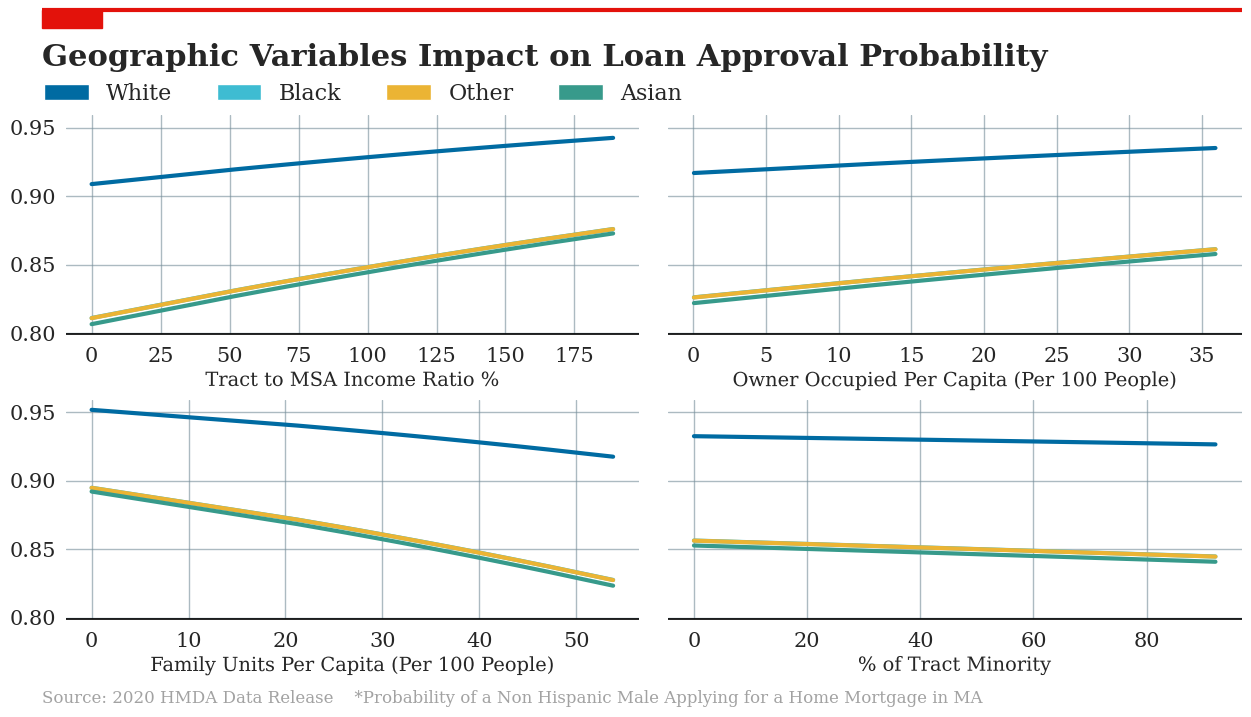

In [32]:
mympl(backround_color='white')

fig, axes = plt.subplots(2, 2, figsize=FIG_SIZE, dpi=DPI, sharey=True)
axes = axes.flatten()
for ax in axes:
    ax.set_axisbelow(True)
    ax.spines["bottom"].set_visible(True)
    ax.spines["bottom"].set_capstyle("butt")
    ax.spines["bottom"].set_lw(1.2)
    ax.spines["bottom"].set_color('black')
    ax.yaxis.set_tick_params(length=3, width=1.2)
    ax.tick_params(left=False)
    ax.grid(which="major", axis='both', color='#758D99', alpha=0.6, zorder=1)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)

race_color_lookup = {'White': cc.BAR_COLORS[0], 
                     'Black': cc.BAR_COLORS[1], 
                     'Other': cc.BAR_COLORS[2], 
                     'Asian': cc.BAR_COLORS[3]}    
    
i = 0 
for col, data in cont_data.items():
    if col in geo_cols:
        print(name_lookup[col])
        axes[i].set_xlabel(name_lookup[col], fontsize=14, path_effects=PATH_EFFECTS)
        for race in data.keys():
            axes[i].plot(variable_range_lookup[col], data[race], color=race_color_lookup[race], lw=3)
        i += 1

fig.subplots_adjust(top=0.80, bottom=0.08)
fig.subplots_adjust(left=.02, right=1, wspace=0.05 , hspace=0.30)
add_text = '    *Probability of a Non Hispanic Male Applying for a Home Mortgage in MA'
fig.text(0, -.04, SOURCE_TEXT + add_text, color="#a2a2a2", fontsize=12)
#Add line and rectangle on top.
fig.add_artist(lines.Line2D([0, 1], [0.95, 0.95], lw=3, color=cc.ECON_RED, solid_capstyle="butt"))
fig.add_artist(patches.Rectangle((0, 0.925), 0.05, 0.025, color=cc.ECON_RED))
# Add title
fig.text(0, 0.87, "Geographic Variables Impact on Loan Approval Probability", fontsize=22,fontweight="bold")   
legend_elements = [Patch(facecolor=cc.BAR_COLORS[0], edgecolor='white', label='White'),
                   Patch(facecolor=cc.BAR_COLORS[1], edgecolor='white', label='Black'),
                   Patch(facecolor=cc.BAR_COLORS[2], edgecolor='white', label='Other'),
                   Patch(facecolor=cc.BAR_COLORS[3], edgecolor='white', label='Asian')]
fig.legend(handles=legend_elements, loc='center', ncol=4, fontsize=16, frameon=False, bbox_to_anchor=(.268, .83))

## Applicant Cols

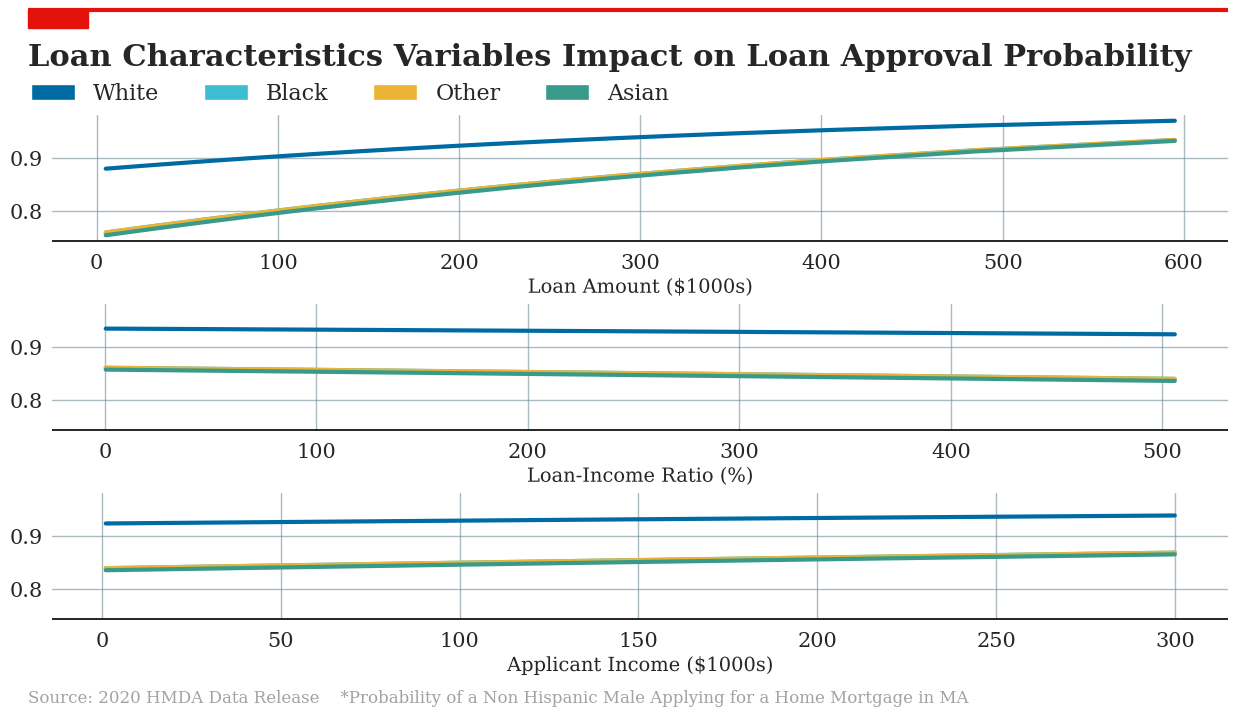

In [24]:
mympl(backround_color='white') #cc.BACKROUND_COLOR

fig, axes = plt.subplots(3, figsize=FIG_SIZE, dpi=DPI, sharey=True)
axes = axes.flatten()
for ax in axes:
    ax.set_axisbelow(True)
    ax.spines["bottom"].set_visible(True)
    ax.spines["bottom"].set_capstyle("butt")
    ax.spines["bottom"].set_lw(1.2)
    ax.spines["bottom"].set_color('black')
    ax.yaxis.set_tick_params(length=3, width=1.2)
    ax.tick_params(left=False)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    ax.grid(which="major", axis='both', color='#758D99', alpha=0.6, zorder=1)

race_color_lookup = {'White': cc.BAR_COLORS[0], 
                     'Black': cc.BAR_COLORS[1], 
                     'Other': cc.BAR_COLORS[2], 
                     'Asian': cc.BAR_COLORS[3]}    
    
i = 0 
for col, data in cont_data.items():
    if col in loan_cols:
        axes[i].set_xlabel(name_lookup[col], fontsize=14, path_effects=PATH_EFFECTS)  
        for race in data.keys():
            axes[i].plot(variable_range_lookup[col], data[race], color=race_color_lookup[race], lw=3)
        i += 1

fig.subplots_adjust(top=0.80, bottom=0.08)
fig.subplots_adjust(left=.02, right=1, wspace=0.05 , hspace=0.5)
add_text = '    *Probability of a Non Hispanic Male Applying for a Home Mortgage in MA'
fig.text(0, -.04, SOURCE_TEXT + add_text, color="#a2a2a2", fontsize=12)
#Add line and rectangle on top.
fig.add_artist(lines.Line2D([0, 1], [0.95, 0.95], lw=3, color=cc.ECON_RED, solid_capstyle="butt"))
fig.add_artist(patches.Rectangle((0, 0.925), 0.05, 0.025, color=cc.ECON_RED))
# Add title
fig.text(0, 0.87, "Loan Characteristics Variables Impact on Loan Approval Probability", fontsize=22,fontweight="bold")   
legend_elements = [Patch(facecolor=cc.BAR_COLORS[0], edgecolor='white', label='White'),
                   Patch(facecolor=cc.BAR_COLORS[1], edgecolor='white', label='Black'),
                   Patch(facecolor=cc.BAR_COLORS[2], edgecolor='white', label='Other'),
                   Patch(facecolor=cc.BAR_COLORS[3], edgecolor='white', label='Asian')]
fig.legend(handles=legend_elements, loc='center', ncol=4, fontsize=16, frameon=False, bbox_to_anchor=(.268, .83))

## Average Loan Approval Rates 

In [25]:
black_df = approval_df[approval_df['Black'] == 1]
white_df = approval_df[approval_df['White'] == 1]
asian_df = approval_df[approval_df['Asian'] == 1]
other_df = approval_df[approval_df['Other'] == 1]
male_df = approval_df[approval_df['Male'] == 1]
female_df = approval_df[approval_df['Female'] == 1]
hispanic_df = approval_df[approval_df['Hispanic'] == 1]
not_hispanic_df = approval_df[approval_df['Not Hispanic'] == 1]

hispanic_approval = hispanic_df['Loan Approved'].mean()
not_hispanic_approval = not_hispanic_df['Loan Approved'].mean()
black_approval = black_df['Loan Approved'].mean()
white_approval = white_df['Loan Approved'].mean()
asian_approval =  asian_df['Loan Approved'].mean()
other_approval =  other_df['Loan Approved'].mean()
male_approval =  male_df['Loan Approved'].mean()
female_approval =  female_df['Loan Approved'].mean()


data = np.array([hispanic_approval, 
                 not_hispanic_approval,
                 black_approval, 
                 white_approval, 
                 asian_approval,
                 other_approval,
                 male_approval, 
                 female_approval]) * 100

Text(1.48, 81, 'Average 76.81%')

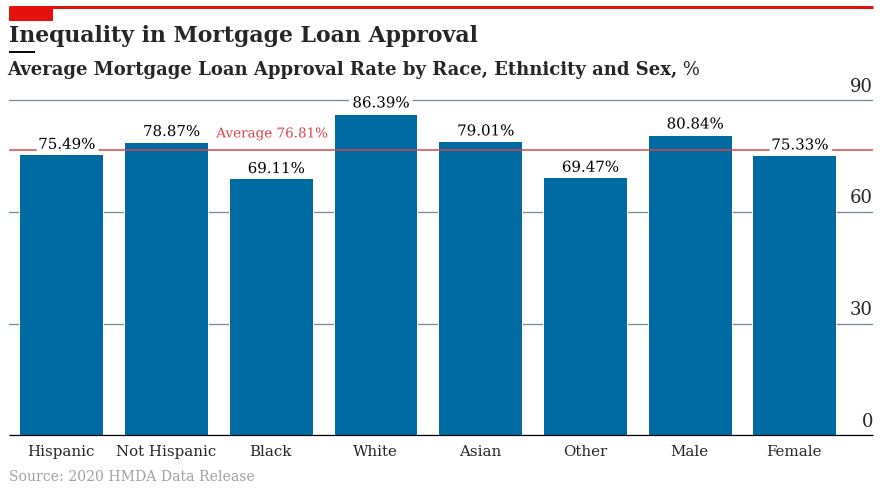

In [26]:
def add_percent_bar_values(x_vals, y_vals, axes, color='black', fontsize=15):
    for x, y in zip(x_vals, y_vals):
        label_text = str(round(y, 2)) + '%'
        axes.text(x-.22, y + (y * .02), label_text, color=color, fontsize=fontsize, path_effects=PATH_EFFECTS)
        
def add_label(x, y, text, color, path_effects, rotation, ax, fontsize=18, fontweight='normal'):
    ax.text(x, y, text, color=color,
        fontsize=fontsize, 
        va="center", ha="left", 
        path_effects=path_effects, 
        rotation=rotation, 
        fontweight=fontweight) 
    
def create_yticks(lower, upper, n_ticks):
    tick_width = (upper - lower) // n_ticks
    myticks = [lower]
    for _ in range(n_ticks - 1):
        new_tick = tick_width + lower
        myticks.append(new_tick)
        lower = new_tick 
    return myticks

fig, axes = plt.subplots(1, figsize=FIG_SIZE, sharey=True)

axes.spines["bottom"].set_visible(True)
axes.spines["bottom"].set_capstyle("butt")
axes.spines["bottom"].set_lw(1.2)
axes.spines["bottom"].set_color('black')

labels = ['Hispanic', 'Not Hispanic', 'Black', 'White', 'Asian', 'Other', 'Male', 'Female']

ax_x_max = 7.75
ax_x_min = -.5

r = np.arange(len(labels))
axes.xaxis.set_ticks(r)
axes.xaxis.set_ticklabels(labels, fontsize=15, fontweight=100)
axes.xaxis.set_tick_params(length=6, width=1.2)
axes.set_xlim(ax_x_min , ax_x_max)
axes.grid(axis="y", color=cc.GRID_COLOR, lw=1.3, which="major")
axes.yaxis.set_tick_params(labelleft=False, length=0)

axes.bar(r, data, edgecolor='white', color=cc.BAR_COLORS[0])#, edgecolor='white', color=cc.BAR_COLORS[0])

ax_y_max = 120
ax_y_min = 0
number_y_ticks = 4

myticks = create_yticks(ax_y_min, ax_y_max, number_y_ticks)
# # Setting the yticks are important for formatting further down
axes.yaxis.set_ticks(myticks)
# # Pad between ytick label and y line
PAD = ax_y_max * 0.02
for label in myticks:
     axes.text(ax_x_max, label + PAD, int(label), ha="right", va="baseline", fontsize=18, fontweight=100)

#axes.set_ylim(bottom=ax_y_min, top=ax1_y_max) 

add_percent_bar_values(r, data, axes)


# Post plotting touch ups 
fig.add_artist(lines.Line2D([0, 0.03], [1.136, 1.136],  lw=1.9, color="black", solid_capstyle="butt", transform=axes.transAxes))    
text = "<name:serif, size:18><weight:bold>Average Mortgage Loan Approval Rate by Race, Ethnicity and Sex,</> %</>"
flexitext(-.002, 1.11, text, va="top", ax=axes)

## Add in sources 
fig.subplots_adjust(top=0.82, bottom=0.15)
fig.subplots_adjust(left=0, right=1)
fig.text(0, 0.06, SOURCE_TEXT, color="#a2a2a2", fontsize=14)
#fig.text(.3, 0.06, '*White, Black, and Asian are non hispanic' , color= "#a2a2a2", fontsize=14)

    
# Add line and rectangle on top.
fig.add_artist(lines.Line2D([0, 1], [1, 1], lw=3, color=cc.ECON_RED, solid_capstyle="butt"))
fig.add_artist(patches.Rectangle((0, 0.975), 0.05, 0.025, color=cc.ECON_RED))

# Add title
fig.text(0, 0.93, "Inequality in Mortgage Loan Approval", fontsize=22,fontweight="bold")
# Add subtitle
#fig.text(0, 0.865, "Differentials in Income Quintiles and Mortgage Loan Approval Rates", fontsize=20)




axes.plot([-.5, 8],[data.mean(), data.mean()], color=cc.RED, lw=1.5)
axes.text(1.48, 81, 
        'Average '+ str(round(data.mean(),2)) + '%', 
        color=cc.RED,
        fontsize=13.5, 
        va="center", 
        ha="left", 
        rotation=0,
        path_effects=PATH_EFFECTS)

In [27]:
state_cols = [col for col in approval_df.columns if 'state_code' in col]
white_data = []
black_data = []
other_data = []
asian_data = []
for col in state_cols:
    state_df = approval_df[approval_df[col] == 1]
    black_df = state_df[state_df['Black'] == 1]
    white_df = state_df[state_df['White'] == 1]
    asian_df = state_df[state_df['Asian'] == 1]
    other_df = state_df[state_df['Other'] == 1]
    s = f'State {col[-2:]}, White: {len(white_df)}, Black: {len(black_df)}, Asian: {len(asian_df)}, Other: {len(other_df)}'
    print(s)
    
    white_data.append(white_df['Loan Approved'].mean())
    black_data.append(black_df['Loan Approved'].mean()) 
    other_data.append(other_df['Loan Approved'].mean())  
    asian_data.append(asian_df['Loan Approved'].mean())
    
race_df = pd.DataFrame([white_data, black_data, other_data, asian_data])
state_labels = [col[-2:] for col in state_cols]
race_df.columns = state_labels
race_df = race_df.T
race_df.columns = race_cols

race_df['W_B_Gap'] = race_df['White'] - race_df['Black']
worst_5 = list(race_df.sort_values('W_B_Gap', ascending=False).iloc[0:5].index)
best_5 = list(race_df.sort_values('W_B_Gap', ascending=True).iloc[0:5].index)
#race_df.sort_values('W_B_Gap', ascending=True)

State FL, White: 26843, Black: 19719, Asian: 1676, Other: 1702
State MI, White: 10984, Black: 6908, Asian: 550, Other: 654
State MN, White: 7334, Black: 2823, Asian: 393, Other: 584
State CO, White: 8932, Black: 2008, Asian: 494, Other: 954
State DE, White: 1168, Black: 1631, Asian: 109, Other: 88
State NY, White: 11137, Black: 8449, Asian: 2188, Other: 821
State MS, White: 1846, Black: 7022, Asian: 66, Other: 139
State CA, White: 23087, Black: 10772, Asian: 9679, Other: 3241
State WA, White: 8554, Black: 2773, Asian: 2414, Other: 1262
State AZ, White: 10178, Black: 3029, Asian: 592, Other: 1276
State MO, White: 6879, Black: 3462, Asian: 278, Other: 464
State WI, White: 8119, Black: 2066, Asian: 312, Other: 534
State PA, White: 12168, Black: 7391, Asian: 884, Other: 519
State OR, White: 5315, Black: 816, Asian: 431, Other: 640
State IL, White: 11339, Black: 8313, Asian: 1419, Other: 683
State GA, White: 8955, Black: 21623, Asian: 1186, Other: 675
State NC, White: 12493, Black: 17711, A

## Average Loan Approval Rate by State

Text(0, 0.92, 'Geographic Inequality in Mortgage Loan Approval')

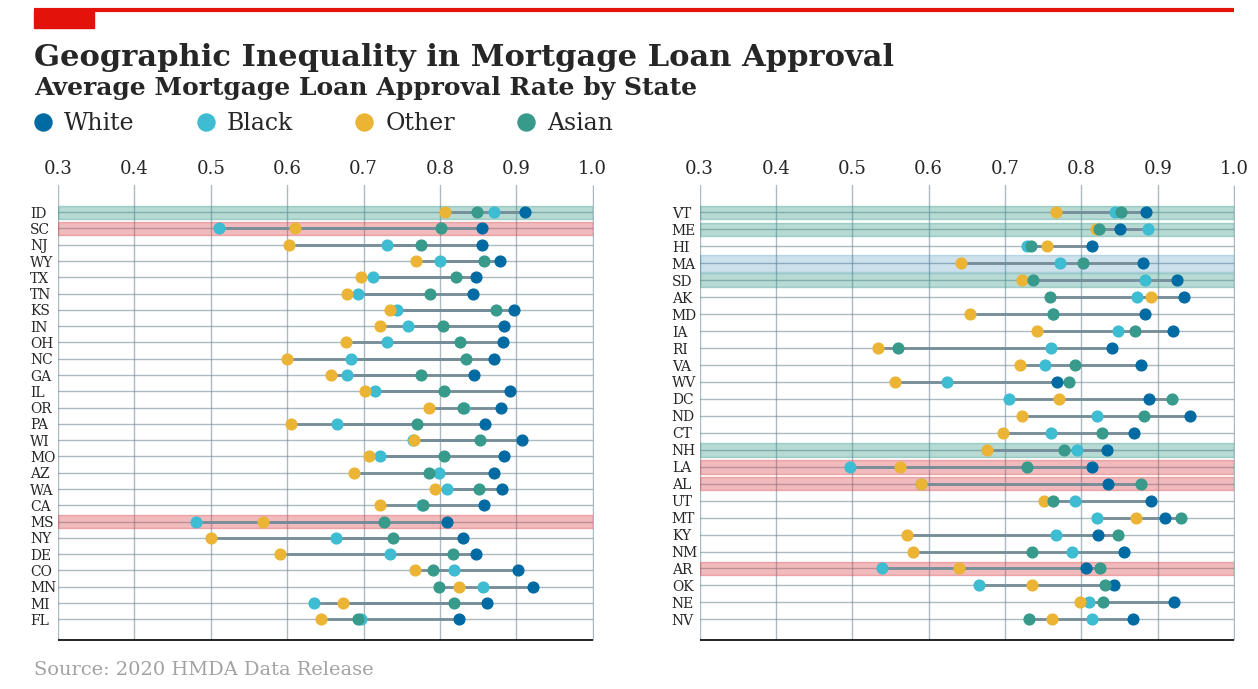

In [28]:
x_max = 500
x_min = 0
y_max = 1000
y_min = 0

mympl(backround_color='white')

fig, axes = plt.subplots(1, 2, figsize=(12, 7), dpi=DPI)
for ax in axes:
    ax.set_axisbelow(True)
    ax.spines["bottom"].set_visible(True)
    ax.spines["bottom"].set_capstyle("butt")
    ax.spines["bottom"].set_lw(1.2)
    ax.spines["bottom"].set_color('black')
    ax.spines["right"].set_visible(True)
    ax.spines["right"].set_capstyle("butt")
    ax.spines["right"].set_lw(.45)
    ax.spines["right"].set_color(cc.GRID_COLOR)
    ax.xaxis.set_tick_params(labelbottom=False, length=0)
    ax.yaxis.set_tick_params(length=3, width=1.2)
    ax.tick_params(left=False)
    ax.grid(which="major", axis='both', color=cc.GRID_COLOR, alpha=0.6, zorder=1)
    
d1_labels = state_labels[0:26] 
    
r = np.arange(len(d1_labels))
axes[0].yaxis.set_ticks(r)
axes[0].yaxis.set_ticklabels(d1_labels, fontsize=10, fontweight=100,  ha='left')
axes[0].yaxis.set_tick_params(length=6, width=1.2, pad=14)
axes[1].axhspan(20.5, 21.5, alpha=0.2, color=cc.BLUE, label='_nolegend_')


i = 0
for w, b, o, a in zip(white_data[0:26], black_data[0:26], other_data[0:26], asian_data[0:26]):
    axes[0].hlines(y=i, xmin=w, xmax=b, 
                   color='#758D99', zorder=2, linewidth=2, alpha=.8, label='_nolegend_' )
    axes[0].hlines(y=i, xmin=o, xmax=a, 
                   color='#758D99', zorder=2, linewidth=2, alpha=.8, label='_nolegend_' )
    axes[0].hlines(y=i, xmin=w, xmax=o, 
                   color='#758D99', zorder=2, linewidth=2, alpha=.8, label='_nolegend_' )
    axes[0].hlines(y=i, xmin=b, xmax=a, 
                   color='#758D99', zorder=2, linewidth=2, alpha=.8, label='_nolegend_' )
   
    axes[0].scatter(w, i, s=60, color=cc.BAR_COLORS[0], zorder=3, label='White')
    axes[0].scatter(b, i, s=60, color=cc.BAR_COLORS[1], zorder=3, label='Black')
    axes[0].scatter(o, i, s=60, color=cc.BAR_COLORS[2], zorder=3, label='Other')
    axes[0].scatter(a, i, s=60, color=cc.BAR_COLORS[3], zorder=3, label='Asian')
    i += 1

legend = axes[0].legend(['White', 'Black', 'Other', 'Asian'], loc=(-.09, 1.09), ncol=4, 
               frameon=False, handletextpad=-.1, handleheight=1, fontsize=17)

for handle in legend.legendHandles:
    handle.set_sizes([150])
    
d2_labels  = state_labels[26:]
r = np.arange(len(d2_labels))
axes[1].yaxis.set_ticks(r)
axes[1].yaxis.set_ticklabels(d2_labels, fontsize=10, fontweight=100, ha='left')
axes[1].yaxis.set_tick_params(length=6, width=1.2, pad=14)


i = 0
for h, b, w, a in zip(white_data[26:], black_data[26:], other_data[26:], asian_data[26:]):
    axes[1].hlines(y=i, xmin=h, xmax=b, 
                   color='#758D99', zorder=2, linewidth=2, alpha=.8, label='_nolegend_' )
    axes[1].hlines(y=i, xmin=b, xmax=w, 
                   color='#758D99', zorder=2, linewidth=2, alpha=.8, label='_nolegend_' )
    axes[1].hlines(y=i, xmin=w, xmax=a, 
                   color='#758D99', zorder=2, linewidth=2, alpha=.8, label='_nolegend_' )
    axes[1].hlines(y=i, xmin=h, xmax=a, 
                   color='#758D99', zorder=2, linewidth=2, alpha=.8, label='_nolegend_' )
   
    axes[1].scatter(h, i, s=60, color=cc.BAR_COLORS[0], zorder=3, label='Hispanic')
    axes[1].scatter(b, i, s=60, color=cc.BAR_COLORS[1], zorder=3, label='Black')
    axes[1].scatter(w, i, s=60, color=cc.BAR_COLORS[2], zorder=3, label='White')
    axes[1].scatter(a, i, s=60, color=cc.BAR_COLORS[3], zorder=3, label='Asian')
    i += 1

axes[0].xaxis.set_tick_params(labeltop=True,     
                         labelbottom=False,  
                         bottom=False,       
                         labelsize=13,      
                         pad=5)  

axes[1].xaxis.set_tick_params(labeltop=True,     
                         labelbottom=False,  
                         bottom=False,       
                         labelsize=13,      
                         pad=5) 
for bad_state in worst_5:
    for ax in axes:
        try:
            get_make_color_bar(axes[0], bad_state, d1_labels)
        except:
            get_make_color_bar(axes[1], bad_state, d2_labels)
            
for bad_state in best_5:
    for ax in axes:
        try:
            get_make_color_bar(axes[0], bad_state, d1_labels, color=cc.GREEN)
        except:
            get_make_color_bar(axes[1], bad_state, d2_labels, color=cc.GREEN)
        
axes[0].set_xlim(.3, 1)
axes[1].set_xlim(.3, 1)
# Post plotting touch ups   
text = "<name:serif, size:18><weight:bold>Average Mortgage Loan Approval Rate by State</></>"
flexitext(-.045, 1.24, text, va="top", ax=axes[0])
## Add in sources 
fig.subplots_adjust(top=0.75, bottom=0.10)
fig.subplots_adjust(left=.02, right=1)
add_text = '    *Probability of a Non Hispanic Male Applying for a Home Mortgage'
fig.text(0, 0.05, SOURCE_TEXT, color="#a2a2a2", fontsize=14)
# Add line and rectangle on top.
fig.add_artist(lines.Line2D([0, 1], [1, 1], lw=3, color=cc.ECON_RED, solid_capstyle="butt"))
fig.add_artist(patches.Rectangle((0, 0.975), 0.05, 0.025, color=cc.ECON_RED))
# Add title
fig.text(0, 0.92, "Geographic Inequality in Mortgage Loan Approval", fontsize=22,fontweight="bold")

## Approval Rates Across Income 

In [29]:
def get_approval_rate(quantile_df):
    ''' Function for getting the approval rating of each race / ethnicity or each quantile'''
    white_a = quantile_df[quantile_df['White'] == 1]['Loan Approved'].mean()
    black_a = quantile_df[quantile_df['Black'] == 1]['Loan Approved'].mean()
    other_a = quantile_df[quantile_df['Other'] == 1]['Loan Approved'].mean()
    asian_a = quantile_df[quantile_df['Asian'] == 1]['Loan Approved'].mean()
    return white_a, black_a, other_a, asian_a


def get_percent(quantile_df):
    ''' Function for getting the count of each race / ethnicity for each quantile '''
    n_black = len(quantile_df[quantile_df['Black'] == 1])
    n_white = len(quantile_df[quantile_df['White'] == 1])
    n_other = len(quantile_df[quantile_df['Other'] == 1])
    n_asian = len(quantile_df[quantile_df['Asian'] == 1])
    count = [n_white, n_black, n_other, n_asian]
    quanitle_percent = [c / sum(count) for c in count]
    return quanitle_percent
    
def make_graph_data(func, quanitle_list):
    white = []
    black = []
    other = []
    asian = []
    for q in quanitle_list:
        out = func(q)
        white.append(out[0])
        black.append(out[1])
        other.append(out[2])
        asian.append(out[3])
    return np.array([white, black, other, asian])



In [30]:
# Keep the same between plots
number_y_ticks = 6

n_sample = 30_000 # Smallest number we can get to each race
w_df = approval_df[approval_df['White'] == 1].sample(n=n_sample)
b_df = approval_df[approval_df['Black'] == 1].sample(n=n_sample)
o_df = approval_df[approval_df['Other'] == 1].sample(n=n_sample)
a_df = approval_df[approval_df['Asian'] == 1].sample(n=n_sample)
use_df = pd.concat([w_df, b_df, o_df, a_df])
print(df.shape)

# Create the samples here
income_quantiles = use_df['Applicant Income'].quantile([.20, .40, .60, .80]).values
q1 =  use_df[use_df['Applicant Income'] < income_quantiles[0]]
q2 =  use_df[(use_df['Applicant Income'] < income_quantiles[1]) & (use_df['Applicant Income'] > income_quantiles[0])]
q3 =  use_df[(use_df['Applicant Income'] < income_quantiles[2]) & (use_df['Applicant Income'] > income_quantiles[1])]
q4 =  use_df[(use_df['Applicant Income'] < income_quantiles[3]) & (use_df['Applicant Income'] > income_quantiles[2])]
q5 =  use_df[use_df['Applicant Income'] > income_quantiles[3]]

quantiles = [q1, q2, q3, q4, q5]
avg_income = [q['Applicant Income'].mean() for q in quantiles] # Find avg income for each income quantile

# Build our data 
quanitle_percent = make_graph_data(get_percent, quantiles)
approval_rate = make_graph_data(get_approval_rate, quantiles)

labels = ['Q-One', 'Q-Two', 'Q-Three', 'Q-Four', 'Q-Five']
# Now for each quantile find the approval rate for each race.

(670329, 71)


Text(0, 0.865, 'Race Differentials in Income Quintiles and Mortgage Loan Approval Rates')

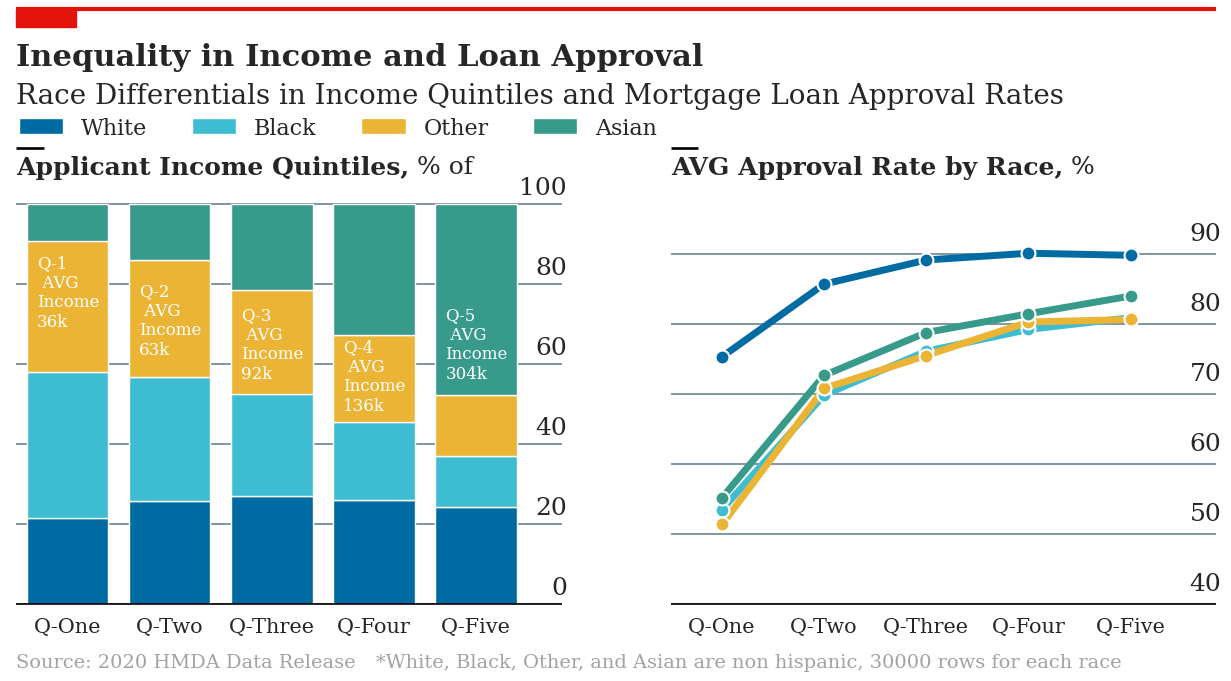

In [31]:
fig, axes = plt.subplots(1, 2, figsize=FIG_SIZE, dpi=DPI)
fig.subplots_adjust(left=0, right=1)

for ax in axes:
    ax.set_axisbelow(True)
    ax.spines["bottom"].set_visible(True)
    ax.spines["bottom"].set_capstyle("butt")
    ax.spines["bottom"].set_lw(1.2)
    ax.spines["bottom"].set_color('black')
    
    ax.yaxis.set_tick_params(labelleft=False, length=0)
    ax.grid(axis="y", color=cc.GRID_COLOR, lw=1.3)
       
# First Plot is stacked bar with percent comp 
r = np.arange(len(labels))
d1 = quanitle_percent[0] * 100
d2 = quanitle_percent[1] * 100
d3 = quanitle_percent[2] * 100
d4 = quanitle_percent[3] * 100


# Spines and ticks
ax0_x_max = 4.84
ax0_x_min = -.5
ax0_y_max = 120
ax0_y_min = 0
#axes[0].set_ylim(ax0_y_min, ax0_y_max)
myticks = create_yticks(ax0_y_min, ax0_y_max, number_y_ticks)

# Setting the yticks are important for formatting further down
axes[0].yaxis.set_ticks(myticks)
# Pad between ytick label and y line
PAD = ax0_y_max * 0.02
for label in myticks:
    axes[0].text(ax0_x_max +.05, label + PAD, int(label), ha="right", va="baseline", fontsize=18, fontweight=100)

axes[0].xaxis.set_ticks(r)
axes[0].xaxis.set_ticklabels(labels, fontsize=15, fontweight=100)
axes[0].xaxis.set_tick_params(length=6, width=1.2)
axes[0].set_xlim(ax0_x_min, ax0_x_max)

# Plot bar one
axes[0].yaxis.set_tick_params(labelleft=False, length=0)
axes[0].bar(r, d1, edgecolor='white', color=cc.BAR_COLORS[0])#, edgecolor='white', color=cc.BAR_COLORS[0])
axes[0].bar(r, d2, edgecolor='white', color=cc.BAR_COLORS[1], bottom=d1)
axes[0].bar(r, d3, edgecolor='white', color=cc.BAR_COLORS[2], bottom=d1 + d2)
axes[0].bar(r, d4, edgecolor='white', color=cc.BAR_COLORS[3], bottom=d1 + d2 + d3)

height = {0:78, 1:71, 2:65, 3:57, 4:65}
mylabels = []
i = 0
for income in avg_income:
    text = f'Q-{i + 1}\n AVG\nIncome\n' + str(int(income)) + 'k'
    label = {"x": i-.3, "y": height[i], "text": text , "color": 'white', "path_effects":[], 'rotation':0}
    i += 1
    mylabels.append(label)
for label in mylabels:
    add_label(**label, ax=axes[0], fontsize=12)


##########################################################################################################
# Plot Two

approval_rate = approval_rate * 100


x = np.arange(len(approval_rate[0]))
for series, color in zip(approval_rate, cc.BAR_COLORS):
    axes[1].plot(x, series, color=color, lw=5)
    axes[1].scatter(x, series, fc=color, s=100, lw=1.5, ec="white", zorder=12)
    
axes[1].yaxis.set_tick_params(labelleft=False, length=0)    
  
ax1_y_max = 100
ax1_y_min = 40
ax1_x_max = ax0_x_max
ax1_x_min = ax0_x_min
myticks = create_yticks(ax1_y_min, ax1_y_max, number_y_ticks)
# Setting the yticks are important for formatting further down
axes[1].yaxis.set_ticks(myticks)
# Pad between ytick label and y line
PAD = ax1_y_max * 0.02
for label in myticks:
    axes[1].text(ax1_x_max +.05, label + PAD, int(label), ha="right", va="baseline", fontsize=18, fontweight=100)

axes[1].set_ylim(ax1_y_min, ax1_y_max)    
    
axes[1].xaxis.set_ticks(r)
axes[1].xaxis.set_ticklabels(labels, fontsize=15, fontweight=100)
axes[1].xaxis.set_tick_params(length=6, width=1.2)
axes[1].grid(axis="y", color=cc.GRID_COLOR, lw=1.3, which="major")
axes[1].set_xlim(-.5, 4.84)
axes[1].spines["bottom"].set_lw(1.2)
axes[1].spines["bottom"].set_capstyle("butt")
axes[1].set_axisbelow(True)



legend_elements = [Patch(facecolor=cc.BAR_COLORS[0], edgecolor='white', label='White'),
                   Patch(facecolor=cc.BAR_COLORS[1], edgecolor='white', label='Black'),
                   Patch(facecolor=cc.BAR_COLORS[2], edgecolor='white', label='Other'),
                   Patch(facecolor=cc.BAR_COLORS[3], edgecolor='white', label='Asian')]

# Create the figure
fig.legend(handles=legend_elements, loc='center', ncol=4, fontsize=16, frameon=False, bbox_to_anchor=(.268, .83))


# Post plotting touch ups 
fig.add_artist(lines.Line2D([0, 0.05], [1.085, 1.085],  lw=1.9, color="black", solid_capstyle="butt", transform=axes[0].transAxes))   
text = "<name:serif, size:18><weight:bold>Applicant Income Quintiles,</> % of</>"
flexitext(0, 1.07, text, va="top", ax=axes[0])

# Post plotting touch ups 
fig.add_artist(lines.Line2D([0, 0.05], [1.085, 1.085],  lw=1.9, color="black", solid_capstyle="butt", transform=axes[1].transAxes))
#axes[0].add_artist(lines.Line2D([0, 0.05], [1, 1], lw=3, color="black", solid_capstyle="butt", transform=axes[0].transAxes))    
text = "<name:serif, size:18><weight:bold>AVG Approval Rate by Race,</> %</>"
flexitext(0, 1.07, text, va="top", ax=axes[1])

## Add in sources 
fig.subplots_adjust(top=0.75, bottom=0.15)
fig.text(0, 0.06, SOURCE_TEXT, color="#a2a2a2", fontsize=14)
fig.text(.3, 0.06, f'*White, Black, Other, and Asian are non hispanic' + f", {n_sample} rows for each race", color="#a2a2a2", fontsize=14)

    
# Add line and rectangle on top.
fig.add_artist(lines.Line2D([0, 1], [1, 1], lw=3, color=cc.ECON_RED, solid_capstyle="butt"))
fig.add_artist(patches.Rectangle((0, 0.975), 0.05, 0.025, color=cc.ECON_RED))

# Add title
fig.text(0, 0.92, "Inequality in Income and Loan Approval", fontsize=22,fontweight="bold")
# Add subtitle
fig.text(0, 0.865, "Race Differentials in Income Quintiles and Mortgage Loan Approval Rates", fontsize=20)